In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from treelib import Node, Tree
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Задача 1

In [3]:
def prob1(data, label, true_label):
    def classification_counts(column, label, x, true_label):
        pred_pos = column >= x
        pred_neg = ~pred_pos
        label_pos = label == true_label
        label_neg = ~label_pos

        return column[pred_pos & label_neg].count(), \
               column[pred_pos & label_pos].count(), \
               column[pred_neg & label_neg].count(), \
               column[pred_neg & label_pos].count()

    FPrates = []
    TPrates = []
    aucs = []
    for name, column in data.iteritems():
        FPrate = np.zeros(20)
        TPrate = np.zeros(20)
        for i, x in enumerate(np.linspace(np.min(column), np.max(column), 20)):
            FP, TP, TN, FN = classification_counts(column, label, x, true_label)
            TPrate[i] = TP/(TP + FN)
            FPrate[i] = FP/(FP + TN)
        FPrates.append(FPrate)
        TPrates.append(TPrate)
        aucs.append(auc(FPrate, TPrate))

    top3_idx = np.argpartition(aucs, -3)[-3:]

    for i in top3_idx:
        print(f"{data.columns.values.tolist()[i]} - {aucs[i]}")
        plt.plot(FPrates[i], TPrates[i], '-', label=str(data.columns.values.tolist()[i]))
        plt.legend()

word_freq_all - 0.6613574566280039
word_freq_you - 0.6918702879965434
word_freq_your - 0.7610812947459802


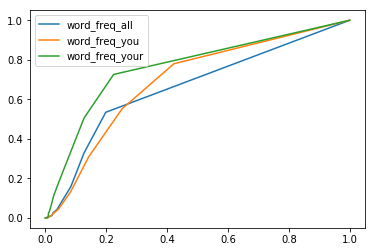

In [4]:
spam = pd.read_csv("../data/spam.csv")
spam_label = spam["label"]
spam = spam.drop("label", axis=1)
  
prob1(spam, spam_label, 1)

28 - 0.9633145711114635
23 - 0.9699342000951323
21 - 0.9670670154854395


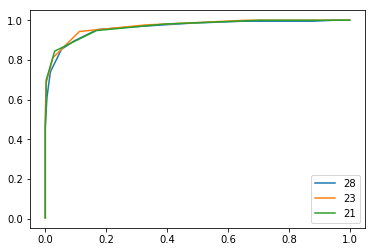

In [5]:
cancer = pd.read_csv("../data/cancer.csv")
cancer_label = cancer["label"]
cancer = cancer.drop("label", axis=1)

prob1(cancer, cancer_label, 'M')

# Задача 2

In [6]:
def prob2(data, label, c):
    train, validate = train_test_split(data, test_size=0.2)
    print(f"Data     1 to 0 ratio: {np.count_nonzero(label == c) / np.count_nonzero(label != c)}")
    print(f"Train    1 to 0 ratio: {np.count_nonzero(label[train.index] == c) / np.count_nonzero(label[train.index] != c)}")
    print(f"Validate 1 to 0 ratio: {np.count_nonzero(label[validate.index] == c) / np.count_nonzero(label[validate.index] != c)}")
    return train, validate

In [7]:
spam_train, spam_validate = prob2(spam, spam_label, 1)

Data     1 to 0 ratio: 0.650286944045911
Train    1 to 0 ratio: 0.651705565529623
Validate 1 to 0 ratio: 0.6446428571428572


In [8]:
cancer_train, cancer_validate = prob2(cancer, cancer_label, 'M')

Data     1 to 0 ratio: 0.5938375350140056
Train    1 to 0 ratio: 0.602112676056338
Validate 1 to 0 ratio: 0.5616438356164384


# Задача 3

In [9]:
class LERule(object):
    def __init__(self, feature, val):
        self.feature = feature
        self.val = val
        
    def __repr__(self):
        return (f"{self.feature} >= {self.val:.2f}")
    
    def apply(self, data):
        crit = data[self.feature] >= self.val
        return data[~crit].index, data[crit].index

class NodeData(object):
    def __init__(self, samples):
        self.samples_idx = samples
        self.rule = True
        self.label = None
        self.inf_gain = None

In [24]:
def accuracy(tree, validate, label):
    def fun(row):
        current = tree.root
        while not tree[current].is_leaf():
            feature, value = tree[current].data.rule.feature, tree[current].data.rule.val
            if (row[feature] >= value):
                current = 2*current + 2
            else:
                current = 2*current + 1
        return tree[current].data.label
     
    x = validate.apply(fun, axis=1)
    tn, fp, fn, tp = confusion_matrix(x, label).ravel()
    
    return (tp+tn)/(tn + fp + fn + tp)

def inf_gain(data, label, unique_labels, rules, node, method='misclass'):
    
    data_size = len(data.index)
    def misclassification_error(idx):
        try:
            return 1 - max([len(data.loc[idx][label == l].index) for l in unique_labels])/len(idx)
        except ZeroDivisionError:
            return 0

    def entropy(idx):
        try:
            a = -sum([np.sum(label[idx] == l) / len(idx) * np.log2(np.sum(label[idx] == l) / len(idx)) for l in unique_labels])
            if not np.isnan(a):
                return a
            else:
                return 0
        except KeyboardInterrupt:
            raise
        except:
            return 0

    def gini(idx):
        try:
            return sum([len(data.loc[idx][label == l].index) * len(data.loc[idx][label != l].index) for l in unique_labels]) / len(idx)**2
        except ZeroDivisionError:
            return 0

    idx = node.data.samples_idx
    idx_len = len(idx)
    fn_dict = {'misclass': misclassification_error, 'entropy': entropy, 'gini': gini}
    fn = fn_dict[method]

    gains = []

    for rule in rules:
        left_idx, right_idx = rule.apply(data.loc[idx])
        gains.append((idx_len*fn(idx) - len(left_idx)*fn(left_idx) - len(right_idx)*fn(right_idx))/data_size)

    best_rule_idx = np.argmax(gains)
    return (rules[best_rule_idx], gains[best_rule_idx])

def prob3(data, validate, label, unique_labels, depth = 9, method = 'misclass'):
    n = 0
    tree = Tree()
    tree.create_node("root", n, data=NodeData(data.index))
    
    while tree.depth() <= depth:
        if all([leaf.data.label is not None for leaf in tree.leaves()]):
            break
            
        for node in tree.leaves():
            if node.data.label is not None:
                continue

            node_labels = label.loc[node.data.samples_idx].unique()
            if len(node_labels) == 1:
                node.tag += f", class: {node_labels[0]}"
                node.data.label = node_labels[0]
                continue

            rules = []
            for name, column in data.loc[node.data.samples_idx].iteritems():
                tholds = np.linspace(np.min(column), np.max(column), 10)
                rules += [LERule(name, t) for t in tholds]

            best_rule, node.data.inf_gain = inf_gain(data, label, unique_labels, rules, node, method=method)
            node.data.rule = best_rule

            left_idx, right_idx = best_rule.apply(data.loc[node.data.samples_idx])
            if len(left_idx) == 0 or len(right_idx) == 0:
                df = label.loc[node.data.samples_idx]
                mode = df.mode()[0]
                node.tag += f", class: {mode}"
                node.data.label = mode
            else:
                tree.create_node(f"otherwise, size={len(left_idx)}, id={2*node.identifier+1}", 2*node.identifier+1, data=NodeData(left_idx), parent=node.identifier)
                tree.create_node(f"{best_rule}, size={len(right_idx)}, id={2*node.identifier+2}", 2*node.identifier+2, data=NodeData(right_idx), parent=node.identifier)
                #print(label.loc[right_idx])
                #n *= 2

        treeD = deepcopy(tree)
        for node in treeD.leaves():
            if node.data.label is None:
                if len(node.data.samples_idx):
                    df = label.loc[node.data.samples_idx]
                    mode = df.mode()[0]
                    node.tag += f", class: {mode}"
                    node.data.label = mode
                else:
                    treeD.remove_node(node.identifier)
                    
        #tree.show()
        print(f"Depth {treeD.depth()} - {accuracy(treeD, validate, label[validate.index])}")
    return treeD

In [11]:
print('Spam')
print("Misclassification error:")
prob3(spam_train, spam_validate, spam_label, [0, 1], method='misclass')

Spam
Misclassification error:
Depth 1 - 0.7307274701411509
Depth 2 - 0.7839305103148752
Depth 3 - 0.8034744842562432
Depth 4 - 0.8512486427795874
Depth 5 - 0.8642779587404995
Depth 6 - 0.8740499457111836
Depth 7 - 0.8675352877307275
Depth 8 - 0.8881650380021715
Depth 9 - 0.8935939196525515
Depth 10 - 0.8990228013029316


In [21]:
print("Entropy:")
prob3(spam_train, spam_validate, spam_label, [0, 1], method='entropy')

Entropy:
Depth 1 - 0.7307274701411509
Depth 2 - 0.762214983713355
Depth 3 - 0.8110749185667753
Depth 4 - 0.8121606948968513
Depth 5 - 0.8577633007600435
Depth 6 - 0.8816503800217155
Depth 7 - 0.8925081433224755
Depth 8 - 0.8979370249728555
Depth 9 - 0.8957654723127035
Depth 10 - 0.8990228013029316


In [22]:
print("Gini:")
prob3(spam_train, spam_validate, spam_label, [0, 1], method='gini')

Gini:
Depth 1 - 0.7307274701411509
Depth 2 - 0.762214983713355
Depth 3 - 0.8197611292073833
Depth 4 - 0.8393051031487514
Depth 5 - 0.8436482084690554
Depth 6 - 0.8838219326818675
Depth 7 - 0.8957654723127035
Depth 8 - 0.8979370249728555
Depth 9 - 0.9011943539630836
Depth 10 - 0.9077090119435396


In [25]:
print("Misclassification error:")
prob3(cancer_train, cancer_validate, cancer_label, ['B', 'M'], depth = 6, method='misclass')

Misclassification error:
Depth 1 - 0.8771929824561403
Depth 2 - 0.9473684210526315
Depth 3 - 0.9035087719298246
Depth 4 - 0.9298245614035088
Depth 5 - 0.9210526315789473
Depth 5 - 0.9210526315789473


In [26]:
print("Entropy:")
prob3(cancer_train, cancer_validate, cancer_label, ['B', 'M'], method='entropy')

Entropy:
Depth 1 - 0.8771929824561403
Depth 2 - 0.9035087719298246
Depth 3 - 0.9298245614035088
Depth 4 - 0.9298245614035088
Depth 5 - 0.9210526315789473
Depth 6 - 0.9210526315789473
Depth 6 - 0.9210526315789473


In [27]:
print("Gini:")
prob3(cancer_train, cancer_validate, cancer_label, ['B', 'M'], depth = 6, method='gini')

Gini:
Depth 1 - 0.8771929824561403
Depth 2 - 0.8947368421052632
Depth 3 - 0.8947368421052632
Depth 4 - 0.8947368421052632
Depth 5 - 0.9210526315789473
Depth 6 - 0.9210526315789473
Depth 7 - 0.9210526315789473


# Задача 4

In [28]:
best_misclass_cancer = prob3(cancer_train, cancer_validate, cancer_label, ['B', 'M'], depth=1, method='misclass')
best_ent_cancer = prob3(cancer_train, cancer_validate, cancer_label, ['B', 'M'], depth=3, method='entropy')
best_gini_cancer = prob3(cancer_train, cancer_validate, cancer_label, ['B', 'M'], depth=1, method='gini')

Depth 1 - 0.8771929824561403
Depth 2 - 0.9473684210526315
Depth 1 - 0.8771929824561403
Depth 2 - 0.9035087719298246
Depth 3 - 0.9298245614035088
Depth 4 - 0.9298245614035088
Depth 1 - 0.8771929824561403
Depth 2 - 0.8947368421052632


In [33]:
best_misclass_spam = prob3(spam_train, spam_validate, spam_label, [0, 1], depth=9, method='misclass')
best_ent_spam = prob3(spam_train, spam_validate, spam_label, [0, 1], depth=9, method='entropy')
best_gini_spam = prob3(spam_train, spam_validate, spam_label, [0, 1], depth=9, method='gini')

Depth 1 - 0.7307274701411509
Depth 2 - 0.7839305103148752
Depth 3 - 0.8034744842562432
Depth 4 - 0.8512486427795874
Depth 5 - 0.8642779587404995
Depth 6 - 0.8740499457111836
Depth 7 - 0.8675352877307275
Depth 8 - 0.8881650380021715
Depth 9 - 0.8935939196525515
Depth 10 - 0.8990228013029316
Depth 1 - 0.7307274701411509
Depth 2 - 0.762214983713355
Depth 3 - 0.8110749185667753
Depth 4 - 0.8121606948968513
Depth 5 - 0.8577633007600435
Depth 6 - 0.8816503800217155
Depth 7 - 0.8925081433224755
Depth 8 - 0.8979370249728555
Depth 9 - 0.8957654723127035
Depth 10 - 0.8990228013029316
Depth 1 - 0.7307274701411509
Depth 2 - 0.762214983713355
Depth 3 - 0.8197611292073833
Depth 4 - 0.8393051031487514
Depth 5 - 0.8436482084690554
Depth 6 - 0.8838219326818675
Depth 7 - 0.8957654723127035
Depth 8 - 0.8979370249728555
Depth 9 - 0.9011943539630836
Depth 10 - 0.9077090119435396


In [34]:
def prob4(tree, train, label, validate, unique_labels = [0, 1]):
    def fun(row):
        current = tree.root
        while not tree[current].is_leaf():
            feature, value = tree[current].data.rule.feature, tree[current].data.rule.val
            if (row[feature] >= value):
                current = 2*current + 2
            else:
                current = 2*current + 1
        return np.sum(label.loc[tree[current].data.samples_idx] == unique_labels[1]) / len(tree[current].data.samples_idx)

    pr = validate.apply(fun, axis=1)
    auc_ = roc_auc_score(label.loc[validate.index].values, pr)
    fpr, tpr, _ = roc_curve(label.loc[validate.index].values, pr, pos_label=unique_labels[1])
    print(f"ROC-AUC = {auc_}")
    plt.plot(fpr, tpr)

ROC-AUC = 0.9507183427998663


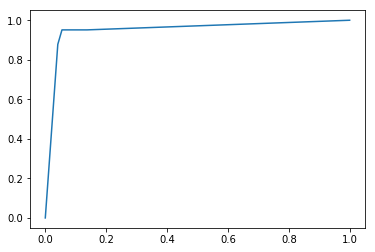

In [35]:
prob4(best_misclass_cancer, cancer_train, cancer_label, cancer_validate, ['B', 'M'])

ROC-AUC = 0.9298362846642165


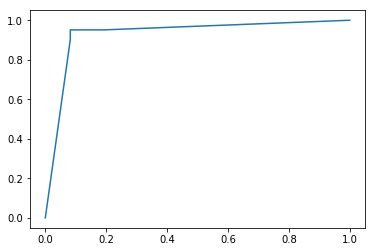

In [36]:
prob4(best_ent_cancer, cancer_train, cancer_label, cancer_validate, ['B', 'M'])

ROC-AUC = 0.9452054794520548


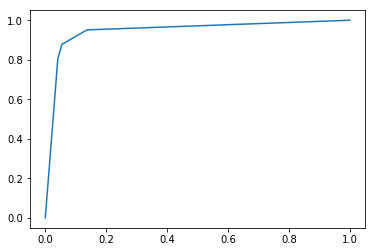

In [37]:
prob4(best_gini_cancer, cancer_train, cancer_label, cancer_validate, ['B', 'M'])

ROC-AUC = 0.908824693312228


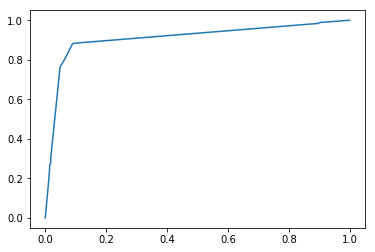

In [38]:
prob4(best_misclass_spam, spam_train, spam_label, spam_validate, [0, 1])

ROC-AUC = 0.9261995449149188


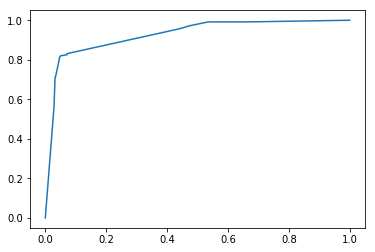

In [39]:
prob4(best_ent_spam, spam_train, spam_label, spam_validate, [0, 1])

ROC-AUC = 0.9217031064503364


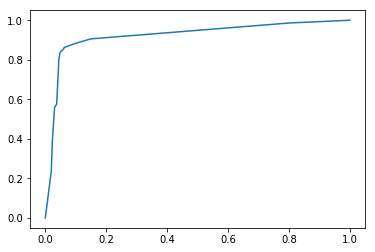

In [40]:
prob4(best_gini_spam, spam_train, spam_label, spam_validate, [0, 1])